# Basic NLP starter kit

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

## Loading the Data

Use the following code to read in the JSON Reddit data: 

In [2]:
from reddit import load

# add additional subreddits below or comment them out with #
subreddits = """\
#https://www.reddit.com/r/AirBnB/
#https://www.reddit.com/r/AmazonFlexDrivers/
#https://www.reddit.com/r/Etsy/
#https://www.reddit.com/r/InstacartShoppers/
#https://www.reddit.com/r/TaskRabbit
#https://www.reddit.com/r/beermoney/
https://www.reddit.com/r/couriersofreddit
#https://www.reddit.com/r/doordash/
#https://www.reddit.com/r/freelance/
https://www.reddit.com/r/lyftdrivers/
#https://www.reddit.com/r/turo/
https://www.reddit.com/r/uberdrivers/
#https://www.reddit.com/r/ridesharedrivers/
"""

data = load(subreddits.split())

loaded 2999 reddit submissions


## Basic NLP in Python with Spacy

In [3]:
nlp = spacy.load('en_core_web_md') # disable=['parser', 'ner'])
spacy_stopwords = nlp.Defaults.stop_words

# Number of stop words:
print('Number of stop words: %d' % len(spacy_stopwords))

# First ten stop words:
print('First ten stop words: %s' % list(spacy_stopwords)[:20])

Number of stop words: 326
First ten stop words: ['down', 'everything', 'afterwards', '‘s', 'which', 'whose', 'nothing', 'without', 'nine', 'hers', 'wherein', '‘ll', '‘d', 'eight', 'see', "'m", 'six', 'wherever', 'i', 'behind']


In [4]:
# named entity recognition

doc = nlp(u"""Half of the 25,000 Uber drivers in Montreal are on strike today demanding a guaranteed hourly wage of at least $18.""")

entities=[(i, i.label_, i.label) for i in doc.ents]
entities

[(Half, 'CARDINAL', 397),
 (25,000, 'CARDINAL', 397),
 (Montreal, 'GPE', 384),
 (today, 'DATE', 391),
 (at least $18, 'MONEY', 394)]

In [5]:
displacy.render(doc, style="ent", jupyter=True)

In [6]:
doc = nlp("This is a sentence.")

# part of speech (POS) tagging
for word in doc:
    print(word.text, word.pos_)

This DET
is AUX
a DET
sentence NOUN
. PUNCT


In [7]:
# dependency parsing
for chunk in doc.noun_chunks:
   print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

displacy.render(doc, style="dep", jupyter=True)

a sentence sentence attr is


## Text Preprocessing and Normalization

It sometimes helps to clean up the input text by removing stop words, punctuation, and replacing words with their base or dictionary form (lemmatization). Each of these steps is problem/task specific and you should consider if this is appropriate in your case.

In [8]:
from cleaning import normalize

In [9]:
text = "The quick brown fox jumps over the lazy dog."

In [10]:
normalize(nlp, text)

'quick brown fox jump lazy dog'

## Sentiment Analysis

You could train your own sentiment model on labelled data (IMDB reviews: https://ai.stanford.edu/~amaas/data/sentiment/) but let's take one that is pretrained and ready to go in the TextBlob package:

In [11]:
docs = [d['title'] + ' ' + d['text'] for d in data]

In [12]:
from textblob import TextBlob

TextBlob(docs[0]).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [13]:
docs_sentiment = [TextBlob(d).sentiment for d in docs]

df_sentiment = pd.DataFrame([
    (doc['title'], doc['text'], sent.polarity, sent.subjectivity)
        for doc, sent in zip(data, docs_sentiment)],
    columns=['title', 'text', 'polarity', 'subjectivity'])
df_sentiment.sort_values(by='polarity', inplace=True)

In [14]:
# positive sentiment
df_sentiment[-5:]

,title,text,polarity,subjectivity
1015,Best week ever!,,1.0,0.30
460,"The order went smoothly, I am a happy Monday c...",,1.0,1.00
1289,The best ride I've ever had!,,1.0,0.30
908,Happy hump day!,,1.0,1.00
1571,What a great morning!,,1.0,0.75


In [15]:
# negative sentiment
df_sentiment[:5]

,title,text,polarity,subjectivity
1913,This Scheduled pickup never happened and the r...,,-1.0,1.0
1331,Just when you think you've seen the worst rate...,,-1.0,1.0
512,Disgusting 🤢,Just saw someone bring their hot/cold bag into...,-1.0,1.0
776,UE is the worst. I turned it on today just to ...,,-1.0,1.0
1051,The worst,,-1.0,1.0


In [16]:
import altair as alt

alt.Chart(df_sentiment.sample(1000)).mark_point(size=50).encode(
    alt.X('polarity'),
    alt.Y('subjectivity'),
    tooltip=['title', 'polarity', 'subjectivity']
).properties(
    width=800,
    height=400
)

alt.Chart(...)

## Word and Document Vectors

Embedding models learn an optimal way to map a word, sentence, or document to a vector such that words, sentences, etc with similar meaning or that occur in similar contexts map to nearby regions in this space. Then it is possible to build a document classifier in this space or find documents or sections of documents most related to a given query (document relevance and question answering systems).

Let's use the built-in learned vector representations shipped with Spacy here but also keep in mind that there are many word2vec, sent2vec, doc2vec implementations and pretrained models out there.

In [17]:
nlp('cat').vector[:10]

array([-0.15067 , -0.024468, -0.23368 , -0.23378 , -0.18382 ,  0.32711 ,
       -0.22084 , -0.28777 ,  0.12759 ,  1.1656  ], dtype=float32)

In [18]:
# using cosine similarity here
nlp('cat').similarity(nlp('dog'))  # similar

0.8016854705531046

In [19]:
nlp('cat').similarity(nlp('broken'))   # not similar

0.30218005181582075

In [20]:
nlp('broken').similarity(nlp('damaged'))   # similar

0.6153508035414617

In [21]:
nlp('pain').similarity(nlp('suffering'))   # similar

0.6852391294042814

In [22]:
from numpy import dot
from numpy.linalg import norm

king = nlp('king').vector
man = nlp('man').vector
woman = nlp('woman').vector
queen = nlp('queen').vector

# cosine similarity
cos_sim = lambda a, b: dot(a, b) / (norm(a) * norm(b))

# king - man + woman \approx queen
cos_sim((king - man) + woman, queen)

0.78808445

In [23]:
italy = nlp('Italy').vector
rome = nlp('Rome').vector
france = nlp('France').vector
paris = nlp('Paris').vector

# italy - rome + paris \approx france
cos_sim((italy - rome) + paris, france)

0.76057756

We can also use a pretrained model more appropriate for dealing with sentences as Spacy's model just averages word vectors which doesn't always work best for capturing the semantic meaning:

In [24]:
sents = [
    "The quick brown fox jumps over the lazy dog.",
    "This is a sentence for which I would like to compute an embedding.",
    "The slow dog rolled under the fast fox."
]

In [25]:
import tensorflow as tf
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [26]:
embeddings = embed(sents)

print(cos_sim(embeddings[0], embeddings[1]))
print(cos_sim(embeddings[0], embeddings[2]))

0.045298062
0.5716226


Using the above sentence encoder we possibly have better seperation in semantic meaning than Spacy:

In [27]:
print(cos_sim(nlp(sents[0]).vector, nlp(sents[1]).vector))
print(cos_sim(nlp(sents[0]).vector, nlp(sents[2]).vector))

0.7557235
0.92466456


### Visualize word embeddings with PCA:

In [28]:
from sklearn.decomposition import PCA

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['car', 'truck', 'airplane',
         'bird', 'dragon', 'data', 'horse', 'fish' , 'lion',
         'insurance', 'policy', 'coverage', 'risk', 'damage', 'loss',
         'money', 'cost']

# Use PCA to project our vectors down into a 2 dimensional space
pca = PCA(n_components=2)
word_vecs_2d = pca.fit_transform(get_word_vectors(words))

word_vecs_2d

array([[-0.53257867,  4.64954656],
       [ 0.45233599,  4.30317328],
       [ 1.43239684,  2.46908841],
       [ 3.64767249, -0.94351379],
       [ 4.16718867, -1.06069062],
       [-2.16579706, -1.98524289],
       [ 2.63269787,  0.69965051],
       [ 3.46373056, -1.90827617],
       [ 3.97671203, -0.94123711],
       [-3.1756091 ,  1.21412519],
       [-2.71958751, -0.96673556],
       [-2.93484159, -0.5099497 ],
       [-2.07882207, -2.06222181],
       [-1.26587234, -0.87298624],
       [-1.63262158, -1.9767261 ],
       [-1.23272996, -0.05393269],
       [-2.03427459, -0.05407125]])

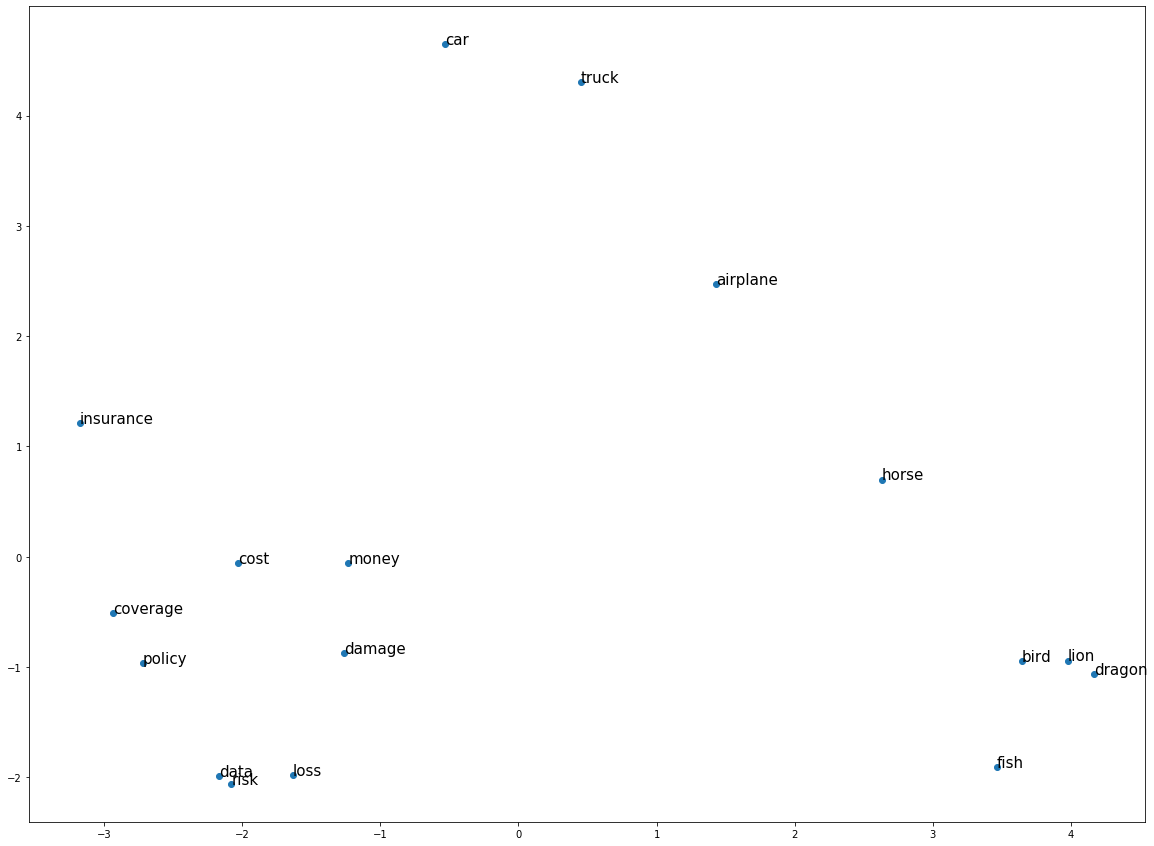

In [29]:
plt.figure(figsize=(20,15))
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])
# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)
plt.show()

At this point you could fit K-nearest neighbour on sentence embeddings and then find all reddit submissions similar to an input sentence

## Topic Analysis

Let's use latent Dirichlet allocation (LDA) to learn a set of topics (word probabiltiy distributions):

In [30]:
docs = [d['title'] + ' ' + d['text'] for d in data]
normalized_docs = [normalize(nlp, d, remove_stops=True, ngrams=True) for d in docs]
docs_tokenized = [d.split() for d in normalized_docs]

In [31]:
from topics import topic_model, topic_vector

In [32]:
model, corpus, coherence, perplexity = topic_model(tokenized_docs=docs_tokenized, num_topics=10, workers=8)

In [33]:
print("coherence: {}\nperplexity: {}".format(coherence, perplexity))

coherence: 0.39770768424006114
perplexity: -6.454205724198961


In [34]:
# let's look at the learned word probabilities per topic:
for topic_id in range(model.num_topics):
    print(', '.join('{0}({1:.2f})'.format(word, probability)
                    for word, probability in model.show_topic(topic_id, topn=5)))

lyft(0.04), ride(0.03), pay(0.02), driver(0.02), order(0.01)
driver(0.05), lyft(0.03), uber(0.03), time(0.02), rate(0.01)
pax(0.02), tell(0.02), tip(0.02), ride(0.02), like(0.01)
driver(0.06), uber(0.05), passenger(0.03), lyft(0.02), report(0.01)
tip(0.05), uber(0.04), app(0.03), driver(0.03), day(0.02)
customer(0.05), order(0.04), tip(0.02), pay(0.02), delivery(0.02)
like(0.03), food(0.02), guy(0.02), order(0.01), tip(0.01)
order(0.02), time(0.02), hour(0.02), work(0.02), week(0.02)
car(0.03), tell(0.02), ride(0.02), minute(0.01), pick(0.01)
ride(0.04), uber(0.03), driver(0.02), drive(0.02), lyft(0.02)


In [35]:
topic_vector(model, "free stuff")

array([0.03333887, 0.03336303, 0.03334491, 0.03335132, 0.03333951,
       0.03335099, 0.69986403, 0.03336155, 0.03334223, 0.03334361],
      dtype=float32)

Possible questions we might use this model to answer:

* What is the dominant topic and its percentage contribution in each document?
* What are the most frequently discussed topics?
* Can we discover topics highly related to insurance concepts?

Although LDA provides a list of topics, it doesn't label them. Manual input is required to give meaning to each topic (activities, dates, places, money, ...)